In [0]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.model_selection import train_test_split
from PIL import Image
import requests
import os

In [2]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

from tensorflow.keras import models, layers, optimizers, utils, datasets, preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import resnet, vgg16, inception_v3

tf.random.set_seed(17)

TensorFlow 2.x selected.


In [3]:
!rm -rf cousteau
!git clone https://github.com/datawookie/cousteau.git
  
from cousteau.keras.plot import plot_history

Cloning into 'cousteau'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 18 (delta 6), reused 16 (delta 4), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [4]:
!rm -rf car-dataset # allows us to re-clone the dataset w/ updates and get the changes - if folder exists, clone does not work and we won't get anychanges
!git clone https://github.com/GerardWalsh/car-dataset.git

Cloning into 'car-dataset'...
remote: Enumerating objects: 572, done.
remote: Counting objects: 100% (572/572), done.
remote: Compressing objects: 100% (510/510), done.
remote: Total 572 (delta 94), reused 534 (delta 61), pack-reused 0
Receiving objects: 100% (572/572), 26.95 MiB | 18.73 MiB/s, done.
Resolving deltas: 100% (94/94), done.


In [0]:
image_paths = list(paths.list_images("car-dataset/train"))

images = []
labels = []

for path in image_paths:
  img = preprocessing.image.load_img(path, target_size=(224, 224))
  img = np.expand_dims(img, axis=0)
  
  images.append(img)

  label = path.split(os.path.sep)[-2]
  if label == "7_5":
    label = 0
  elif label == "7":
    label = 1
  elif label == '6':
    label = 2
  else: 
    label = 3
  labels.append(label)

In [0]:
from collections import Counter
Counter(labels).keys()

dict_keys([3, 0, 1, 2])

In [0]:
Counter(labels).values()

dict_values([60, 68, 83, 89])

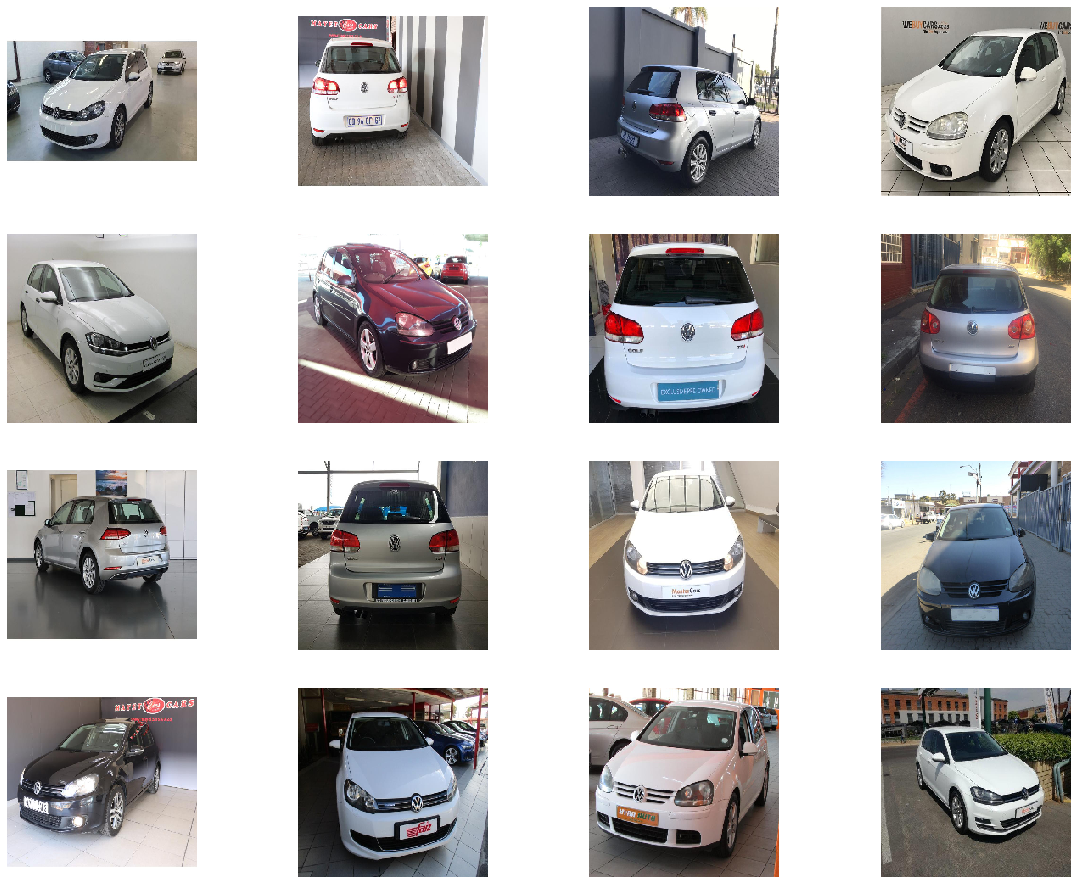

In [0]:
fig = plt.figure(figsize = (20, 16))

for i, img in zip(range(16), random.sample(images, 16)):
  fig.add_subplot(4, 4, i+1)
  plt.axis('off')
  plt.imshow(np.squeeze(img))

plt.show()

In [0]:
datagen = preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [0]:
def augment_image(image, replicates=4):
    images = [image]
    i = 1
    for batch in datagen.flow(image, batch_size=1):
        images.append(batch)
        i += 1
        if i >= replicates:
            break
    return images

In [0]:
REPLICATES = 4

In [0]:
images = [augment_image(image, REPLICATES) for image in images]

In [0]:
images = [image for sublist in images for image in sublist]

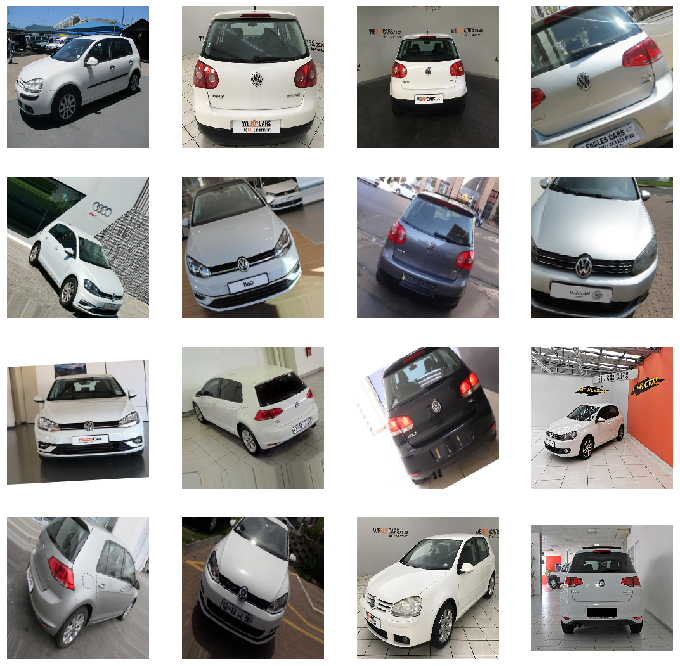

In [0]:
fig = plt.figure(figsize = (12, 12))

for i, img in zip(range(16), random.sample(images, 16)):
  fig.add_subplot(4, 4, i+1)
  plt.axis('off')
  # Transformations result in float32, so cast to uint8.
  plt.imshow(np.squeeze(img).astype('uint8'))

plt.show()

In [0]:
labez = [[label] * REPLICATES for label in labels]

In [0]:
labelz = np.array([label for sublist in labez for label in sublist])

In [13]:
print('Image count (after transform): {}'.format(len(images)), '\n', 'Label count (after transform): {}'.format(len(labelz)))

Image count (after transform): 1200 
 Label count (after transform): 1200


In [0]:
images = np.concatenate(images)

In [0]:
input_shape = images.shape[1:]

In [0]:
images = resnet.preprocess_input(images)

In [0]:
(X_train, X_test, y_train, y_test) = train_test_split(images, labelz, test_size=0.2, random_state=13)

In [18]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

Using TensorFlow backend.


# Shallow CNN

In [0]:
model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size=3, activation = 'relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=2))

model.add(layers.Conv2D(64, kernel_size=3, activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size=2))      

model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(4, activation = 'softmax'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 186624)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               23888000  
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               5

In [0]:
batch_size = 32
epochs = 20

In [0]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

In [29]:
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/20
768/768 [==============================] - 2s 3ms/sample - loss: 1.7403 - accuracy: 0.3880 - val_loss: 2.7231 - val_accuracy: 0.3906
Epoch 2/20
768/768 [==============================] - 1s 2ms/sample - loss: 1.1001 - accuracy: 0.5469 - val_loss: 1.8664 - val_accuracy: 0.3906
Epoch 3/20
768/768 [==============================] - 1s 2ms/sample - loss: 0.8227 - accuracy: 0.6784 - val_loss: 2.2516 - val_accuracy: 0.3385
Epoch 4/20
768/768 [==============================] - 1s 2ms/sample - loss: 0.5810 - accuracy: 0.7930 - val_loss: 1.4918 - val_accuracy: 0.4740
Epoch 5/20
768/768 [==============================] - 1s 2ms/sample - loss: 0.3831 - accuracy: 0.8724 - val_loss: 1.8810 - val_accuracy: 0.3802
Epoch 6/20
768/768 [==============================] - 1s 2ms/sample - loss: 0.2721 - accuracy: 0.9284 - val_loss: 2.1709 - val_accuracy: 0.3281
Epoch 7/20
768/768 [==============================] - 1s 2ms/sample - loss: 0.1802 - accur

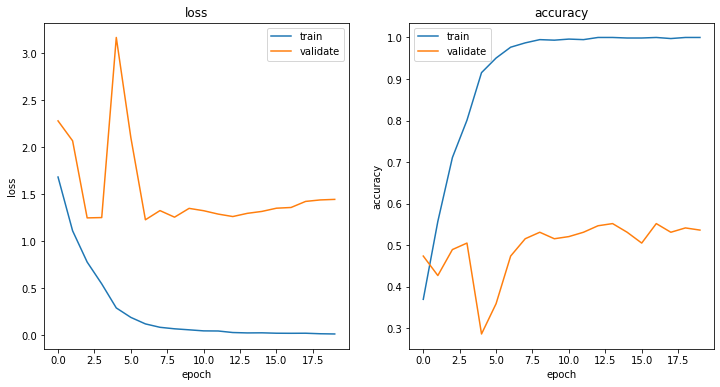

In [0]:
plot_history(history)

In [0]:
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=30,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/30
768/768 [==============================] - 1s 2ms/sample - loss: 0.0152 - accuracy: 1.0000 - val_loss: 1.4627 - val_accuracy: 0.5312
Epoch 2/30
768/768 [==============================] - 1s 2ms/sample - loss: 0.0158 - accuracy: 1.0000 - val_loss: 1.5309 - val_accuracy: 0.5312
Epoch 3/30
768/768 [==============================] - 1s 2ms/sample - loss: 0.0131 - accuracy: 1.0000 - val_loss: 1.5808 - val_accuracy: 0.5156
Epoch 4/30
768/768 [==============================] - 1s 2ms/sample - loss: 0.0150 - accuracy: 1.0000 - val_loss: 1.5880 - val_accuracy: 0.5156
Epoch 5/30
768/768 [==============================] - 1s 2ms/sample - loss: 0.0108 - accuracy: 1.0000 - val_loss: 1.6278 - val_accuracy: 0.5104
Epoch 6/30
768/768 [==============================] - 1s 2ms/sample - loss: 0.0106 - accuracy: 1.0000 - val_loss: 1.6243 - val_accuracy: 0.5417
Epoch 7/30
768/768 [==============================] - 1s 2ms/sample - loss: 0.0116 - accur

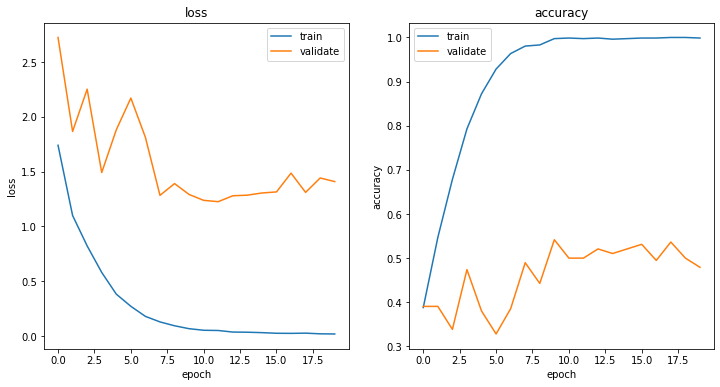

In [30]:
plot_history(history)

In [31]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 50.83% 
Test loss     = 1.374860


## Summary 
Our simple model has stopped learning from the data, as the accuracy is not increasing and our training accuracy is nearly 100%, and will only overfit the data with more training. A more complex model is required - a 3-class accuracy of ~55% is not desireable. 

# Complex model 

In [45]:
base_model = resnet.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

94773248/94765736 [==============================] - 1s 0us/step


In [46]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [0]:
base_model.trainable = True

In [0]:
resnet50 = models.Sequential()

resnet50.add(base_model)
resnet50.add(layers.Flatten())
resnet50.add(layers.Dense(16, activation='relu'))
resnet50.add(layers.BatchNormalization())
resnet50.add(layers.Dropout(0.5))
resnet50.add(layers.Dense(4, activation='softmax'))

In [49]:
resnet50.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_5 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                1605648   
_________________________________________________________________
batch_normalization_5 (Batch (None, 16)                64        
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 68        
Total params: 25,193,492
Trainable params: 25,140,340
Non-trainable params: 53,152
_____________________________________

In [0]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(lr=1e-5),
    metrics=['accuracy']
)

In [51]:
history = resnet50.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=120,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/120
768/768 [==============================] - 15s 19ms/sample - loss: 2.0585 - accuracy: 0.2695 - val_loss: 1.5870 - val_accuracy: 0.3542
Epoch 2/120
768/768 [==============================] - 8s 10ms/sample - loss: 1.3614 - accuracy: 0.4544 - val_loss: 1.4560 - val_accuracy: 0.3542
Epoch 3/120
768/768 [==============================] - 8s 10ms/sample - loss: 0.9935 - accuracy: 0.5924 - val_loss: 1.2945 - val_accuracy: 0.4427
Epoch 4/120
768/768 [==============================] - 8s 10ms/sample - loss: 0.8151 - accuracy: 0.6719 - val_loss: 1.2017 - val_accuracy: 0.4792
Epoch 5/120
768/768 [==============================] - 8s 10ms/sample - loss: 0.7025 - accuracy: 0.7096 - val_loss: 1.1456 - val_accuracy: 0.5365
Epoch 6/120
768/768 [==============================] - 8s 10ms/sample - loss: 0.5999 - accuracy: 0.7747 - val_loss: 1.0699 - val_accuracy: 0.5521
Epoch 7/120
768/768 [==============================] - 8s 10ms/sample - loss:

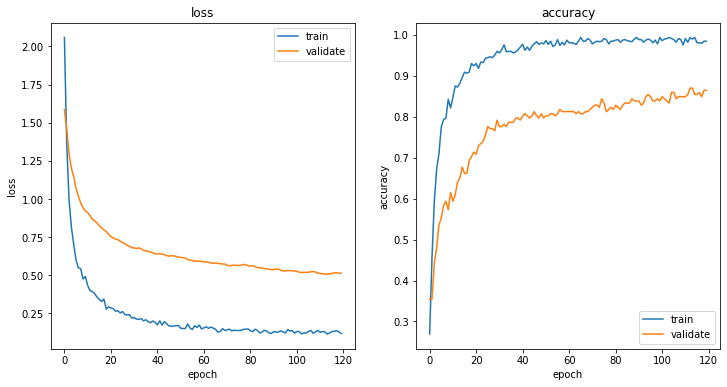

In [52]:
plot_history(history)

In [53]:
history = resnet50.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/20
768/768 [==============================] - 9s 11ms/sample - loss: 0.1223 - accuracy: 0.9883 - val_loss: 0.5122 - val_accuracy: 0.8646
Epoch 2/20
768/768 [==============================] - 9s 11ms/sample - loss: 0.1378 - accuracy: 0.9779 - val_loss: 0.5114 - val_accuracy: 0.8646
Epoch 3/20
768/768 [==============================] - 9s 11ms/sample - loss: 0.1043 - accuracy: 0.9896 - val_loss: 0.5096 - val_accuracy: 0.8594
Epoch 4/20
768/768 [==============================] - 9s 11ms/sample - loss: 0.1265 - accuracy: 0.9870 - val_loss: 0.5019 - val_accuracy: 0.8698
Epoch 5/20
768/768 [==============================] - 9s 11ms/sample - loss: 0.1339 - accuracy: 0.9805 - val_loss: 0.4970 - val_accuracy: 0.8594
Epoch 6/20
768/768 [==============================] - 9s 11ms/sample - loss: 0.1260 - accuracy: 0.9883 - val_loss: 0.4956 - val_accuracy: 0.8698
Epoch 7/20
768/768 [==============================] - 9s 11ms/sample - loss: 0.1143 

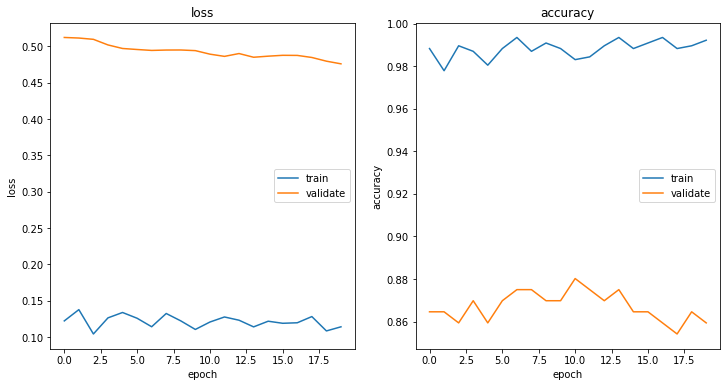

In [54]:
plot_history(history)

In [55]:
score = resnet50.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 87.08% 
Test loss     = 0.492763


## Summary
Resnet50 fits the data relatively well, at 86% accuracy for a 3-class classifaction problem on our test set - could we utilize transfer learning to get a higher accuracy and achieve say 90% accuracy, with our limited data?

# Transfer learning 


In [0]:
base_model = resnet.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

In [0]:
def build_resnet():
  resnet_model = models.Sequential()

  resnet_model.add(base_model)
  resnet_model.add(layers.Flatten())
  resnet_model.add(layers.Dense(1028, activation='relu'))
  resnet_model.add(layers.BatchNormalization())
  resnet_model.add(layers.Dropout(0.5))
  resnet_model.add(layers.Dense(16, activation='relu'))
  resnet_model.add(layers.BatchNormalization())
  resnet_model.add(layers.Dropout(0.5))
  resnet_model.add(layers.Dense(4, activation='softmax'))

  return resnet_model 

resnet50_tl = build_resnet()

In [58]:
def trainable_weights(model):
  return sum([int(tf.size(weights)) for weights in model.trainable_weights])

# How many trainable weights in the base model?
trainable_weights(base_model)

23534592

In [0]:
base_model.trainable = False

In [60]:
trainable_weights(base_model)

0

### Important
This is the crucial step - here we are forcing the convolutional kernels (base model) to keep their weights obtained from training on ImageNet and train only our Fully Connected layers (the classifier). 

In [61]:
resnet50_tl.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_6 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 1028)              103162884 
_________________________________________________________________
batch_normalization_6 (Batch (None, 1028)              4112      
_________________________________________________________________
dropout_6 (Dropout)          (None, 1028)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                16464     
_________________________________________________________________
batch_normalization_7 (Batch (None, 16)               

In [0]:
resnet50_tl.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(lr=1e-3),
    metrics=['accuracy']
)

Since we are only determining weights for our classifier, not the convolutional kernels, we can train for much less epochs. 

In [63]:
history = resnet50_tl.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=30,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/30
768/768 [==============================] - 7s 9ms/sample - loss: 1.5525 - accuracy: 0.4036 - val_loss: 10.6717 - val_accuracy: 0.2917
Epoch 2/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.9634 - accuracy: 0.5964 - val_loss: 2.8257 - val_accuracy: 0.3698
Epoch 3/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.7490 - accuracy: 0.7214 - val_loss: 1.6386 - val_accuracy: 0.4323
Epoch 4/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.5919 - accuracy: 0.7760 - val_loss: 1.2767 - val_accuracy: 0.5104
Epoch 5/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.4971 - accuracy: 0.8333 - val_loss: 1.1001 - val_accuracy: 0.5521
Epoch 6/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.3854 - accuracy: 0.8854 - val_loss: 1.0838 - val_accuracy: 0.5781
Epoch 7/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.3328 - accu

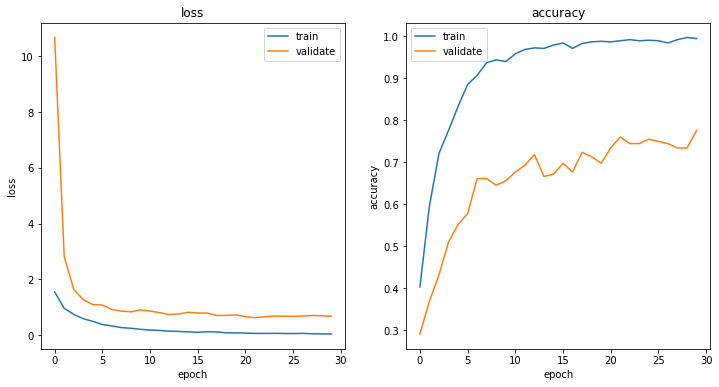

In [64]:
plot_history(history)

In [65]:
score = resnet50_tl.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 70.00% 
Test loss     = 0.710584


# Overfitting
We are overfitting our model to our data - our validation accuracy is much lower than our training accuracy. Let's try use soft label assignments for our training labels to attempt to decrease overfitting. 

In [0]:
resnet50_tl = build_resnet()
base_model.trainable = False

In [67]:
# Check that we are using the pre-trained convolutional kernels
trainable_weights(base_model)

0

In [0]:
from tensorflow.keras.losses import CategoricalCrossentropy
loss = CategoricalCrossentropy(label_smoothing=0.1)

### Important
This is a step towards decreasing over-fitting. Keras/Tensorflow has a soft labelling class that we can utilize directly. 

In [0]:
resnet50_tl.compile(
    loss=loss,
    optimizer=optimizers.Adam(lr=1e-02),
    metrics=['accuracy']
)

In [70]:
history = resnet50_tl.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=30,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/30
768/768 [==============================] - 7s 9ms/sample - loss: 1.4972 - accuracy: 0.3945 - val_loss: 7.4589 - val_accuracy: 0.3177
Epoch 2/30
768/768 [==============================] - 4s 5ms/sample - loss: 1.0540 - accuracy: 0.6107 - val_loss: 3.1934 - val_accuracy: 0.4271
Epoch 3/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.9075 - accuracy: 0.7161 - val_loss: 1.6371 - val_accuracy: 0.5104
Epoch 4/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.7391 - accuracy: 0.8177 - val_loss: 1.3917 - val_accuracy: 0.4271
Epoch 5/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.6325 - accuracy: 0.8932 - val_loss: 1.0540 - val_accuracy: 0.6094
Epoch 6/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.5856 - accuracy: 0.9258 - val_loss: 0.9733 - val_accuracy: 0.6719
Epoch 7/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.5408 - accur

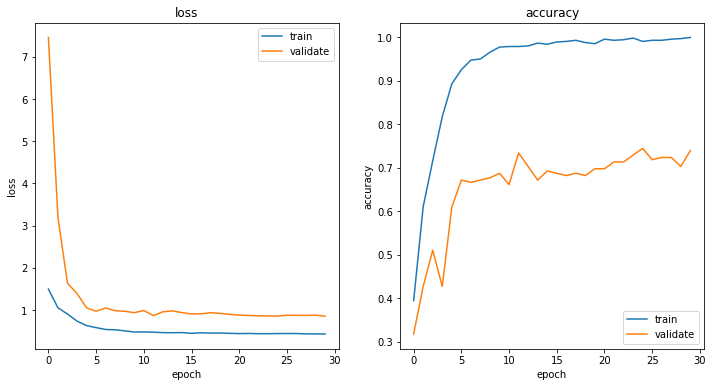

In [71]:
plot_history(history)

In [72]:
score = resnet50_tl.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 66.25% 
Test loss     = 0.897938


## Hyperparameter tuning
Our training heuristics are unstable - let's try a lower learning rate. Transfer learning is promising though, since we achieved 77% accuracy on our test set after only 30 epochs - a feat which took our previous training attempt 120 epochs. 

In [0]:
resnet50_tl = build_resnet()

In [74]:
trainable_weights(base_model)

0

In [0]:
resnet50_tl.compile(
    loss=loss,
    optimizer=optimizers.Adam(lr=1e-2),
    metrics=['accuracy']
)

In [76]:
history = resnet50_tl.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=10,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/10
768/768 [==============================] - 7s 9ms/sample - loss: 1.5203 - accuracy: 0.4128 - val_loss: 8.6549 - val_accuracy: 0.3177
Epoch 2/10
768/768 [==============================] - 4s 5ms/sample - loss: 1.0998 - accuracy: 0.5755 - val_loss: 3.1552 - val_accuracy: 0.3750
Epoch 3/10
768/768 [==============================] - 4s 5ms/sample - loss: 0.9467 - accuracy: 0.6875 - val_loss: 1.6100 - val_accuracy: 0.4844
Epoch 4/10
768/768 [==============================] - 4s 5ms/sample - loss: 0.7379 - accuracy: 0.8216 - val_loss: 1.4553 - val_accuracy: 0.4844
Epoch 5/10
768/768 [==============================] - 4s 5ms/sample - loss: 0.6262 - accuracy: 0.8971 - val_loss: 1.1806 - val_accuracy: 0.5521
Epoch 6/10
768/768 [==============================] - 4s 5ms/sample - loss: 0.5612 - accuracy: 0.9258 - val_loss: 1.1509 - val_accuracy: 0.5677
Epoch 7/10
768/768 [==============================] - 4s 5ms/sample - loss: 0.5329 - accur

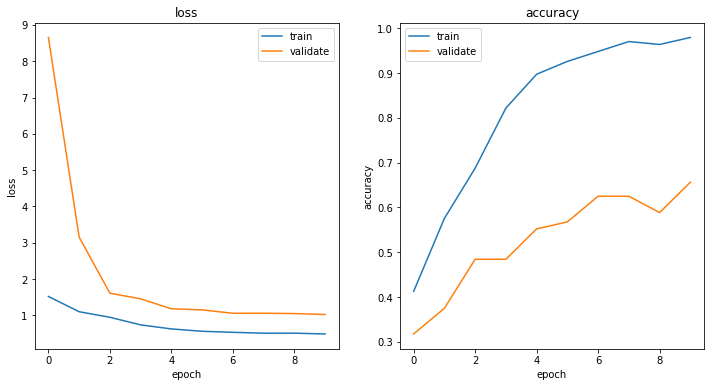

In [77]:
plot_history(history)

In [78]:
score = resnet50_tl.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 57.92% 
Test loss     = 1.082713


# Is there more?

In [79]:
history = resnet50_tl.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=30,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.4797 - accuracy: 0.9844 - val_loss: 0.9908 - val_accuracy: 0.6667
Epoch 2/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.4642 - accuracy: 0.9896 - val_loss: 1.0165 - val_accuracy: 0.6146
Epoch 3/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.4550 - accuracy: 0.9922 - val_loss: 1.0051 - val_accuracy: 0.6562
Epoch 4/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.4663 - accuracy: 0.9831 - val_loss: 1.0451 - val_accuracy: 0.6198
Epoch 5/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.4530 - accuracy: 0.9922 - val_loss: 1.0157 - val_accuracy: 0.6406
Epoch 6/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.4529 - accuracy: 0.9961 - val_loss: 0.9979 - val_accuracy: 0.6562
Epoch 7/30
768/768 [==============================] - 4s 5ms/sample - loss: 0.4542 - accur

In [80]:
score = resnet50_tl.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 62.50% 
Test loss     = 0.943123


## Summary
Utilizing the resnet50 backbone (feature extractor), we managaed to score 76% accuracy on our test set which is similar to our model that trained resnet50 from scratch, convolutional kernels and all. Can we push that classification accuracy higher by updating some of the kernel weights?

# Fine tune ResNet50

In [81]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_3
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [82]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [83]:
# How many trainable weights in the base model?
trainable_weights(base_model)

0

In [84]:
# Make the whole base model trainable (using model property).
base_model.trainable = True
# How many trainable weights in the base model?
trainable_weights(base_model)
# Check that this agrees with the model summary.

23534592

In [0]:
# Set all layers not trainable (using layer properties).
for layer in base_model.layers:
   layer.trainable = False
# Set top two convolutional layers trainable.
for layer in base_model.layers[171:174]:
   layer.trainable = True
    
# How many trainable weights in the base model?
# trainable_weights(base_model)
# Check that this agrees with the model summary.

In [0]:
resnet50_tl.compile(
    loss=loss,
    optimizer=optimizers.Adam(lr=1e-4),
    metrics=['accuracy']
)

In [87]:
resnet50_tl.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_8 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_18 (Dense)             (None, 1028)              103162884 
_________________________________________________________________
batch_normalization_10 (Batc (None, 1028)              4112      
_________________________________________________________________
dropout_10 (Dropout)         (None, 1028)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 16)                16464     
_________________________________________________________________
batch_normalization_11 (Batc (None, 16)               

In [88]:
history = resnet50_tl.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=50,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/50
768/768 [==============================] - 7s 10ms/sample - loss: 0.4295 - accuracy: 0.9974 - val_loss: 0.8855 - val_accuracy: 0.7135
Epoch 2/50
768/768 [==============================] - 4s 5ms/sample - loss: 0.4299 - accuracy: 0.9974 - val_loss: 0.8872 - val_accuracy: 0.7188
Epoch 3/50
768/768 [==============================] - 4s 5ms/sample - loss: 0.4282 - accuracy: 0.9987 - val_loss: 0.8813 - val_accuracy: 0.7396
Epoch 4/50
768/768 [==============================] - 4s 5ms/sample - loss: 0.4278 - accuracy: 0.9974 - val_loss: 0.8902 - val_accuracy: 0.7292
Epoch 5/50
768/768 [==============================] - 4s 5ms/sample - loss: 0.4265 - accuracy: 0.9961 - val_loss: 0.8890 - val_accuracy: 0.7396
Epoch 6/50
768/768 [==============================] - 4s 5ms/sample - loss: 0.4230 - accuracy: 0.9974 - val_loss: 0.8858 - val_accuracy: 0.7500
Epoch 7/50
768/768 [==============================] - 4s 5ms/sample - loss: 0.4295 - accu

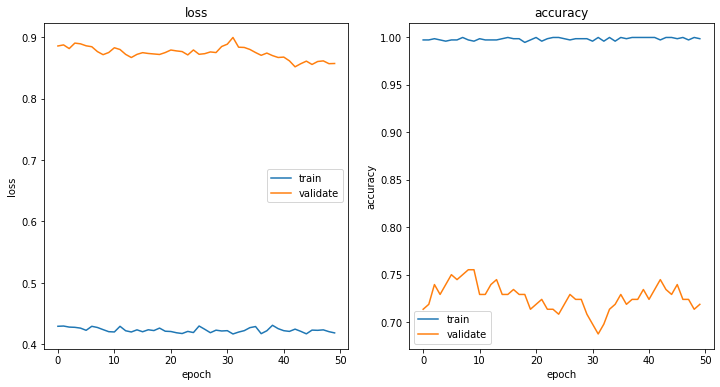

In [89]:
plot_history(history)

In [90]:
history = resnet50_tl.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=10,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/10
768/768 [==============================] - 4s 5ms/sample - loss: 0.4246 - accuracy: 1.0000 - val_loss: 0.8539 - val_accuracy: 0.7292
Epoch 2/10
768/768 [==============================] - 4s 5ms/sample - loss: 0.4235 - accuracy: 0.9974 - val_loss: 0.8480 - val_accuracy: 0.7292
Epoch 3/10
768/768 [==============================] - 4s 5ms/sample - loss: 0.4163 - accuracy: 0.9974 - val_loss: 0.8449 - val_accuracy: 0.7396
Epoch 4/10
768/768 [==============================] - 4s 5ms/sample - loss: 0.4201 - accuracy: 0.9974 - val_loss: 0.8427 - val_accuracy: 0.7396
Epoch 5/10
768/768 [==============================] - 4s 5ms/sample - loss: 0.4204 - accuracy: 1.0000 - val_loss: 0.8441 - val_accuracy: 0.7448
Epoch 6/10
768/768 [==============================] - 4s 5ms/sample - loss: 0.4215 - accuracy: 1.0000 - val_loss: 0.8528 - val_accuracy: 0.7344
Epoch 7/10
768/768 [==============================] - 4s 5ms/sample - loss: 0.4199 - accur

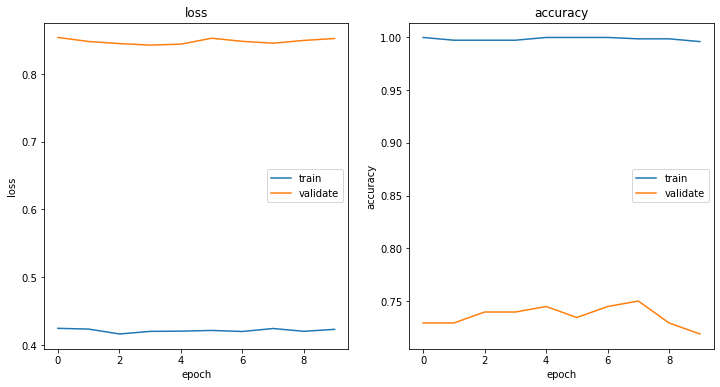

In [91]:
plot_history(history)

In [92]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 50.83% 
Test loss     = 1.374860


# Transfer learning with less complex architechture - VGG16

In [0]:
# base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# vgg = models.Sequential()

# vgg.add(base_model)
# vgg.add(layers.Flatten())
# vgg.add(layers.Dense(16, activation='relu'))
# vgg.add(layers.BatchNormalization())
# vgg.add(layers.Dropout(0.5))
# vgg.add(layers.Dense(4, activation='softmax'))

# base_model.trainable = False

# vgg.compile(
#     loss='categorical_crossentropy',
#     optimizer=optimizers.Adam(lr=1e-4),
#     metrics=['accuracy']
# )

# history = vgg.fit(
#     X_train, y_train,
#     batch_size=batch_size,
#     epochs=50,
#     verbose=1,
#     validation_split=0.2
# )

In [0]:
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [0]:
# base_model.summary()

In [0]:
def build_network(base):

  model = models.Sequential()

  model.add(base)
  model.add(layers.Flatten())
  model.add(layers.Dense(16, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(4, activation='softmax'))

  return model

vgg = build_network(base_model)

In [0]:
vgg.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                401424    
_________________________________________________________________
batch_normalization_6 (Batch (None, 16)                64        
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 68        
Total params: 15,116,244
Trainable params: 15,116,212
Non-trainable params: 32
_________________________________________

In [0]:
base_model.trainable = False

In [0]:
# vgg.summary()

In [0]:
vgg.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(lr=1e-4),
    metrics=['accuracy']
)

In [0]:
history = vgg.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=50,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/50
768/768 [==============================] - 5s 7ms/sample - loss: 2.0907 - accuracy: 0.3307 - val_loss: 3.5959 - val_accuracy: 0.3438
Epoch 2/50
768/768 [==============================] - 5s 6ms/sample - loss: 1.4094 - accuracy: 0.4935 - val_loss: 2.3696 - val_accuracy: 0.3750
Epoch 3/50
768/768 [==============================] - 5s 6ms/sample - loss: 1.1271 - accuracy: 0.5781 - val_loss: 1.3175 - val_accuracy: 0.4635
Epoch 4/50
768/768 [==============================] - 5s 6ms/sample - loss: 0.8466 - accuracy: 0.6771 - val_loss: 1.0215 - val_accuracy: 0.5469
Epoch 5/50
768/768 [==============================] - 5s 6ms/sample - loss: 0.7401 - accuracy: 0.7005 - val_loss: 0.9121 - val_accuracy: 0.6146
Epoch 6/50
768/768 [==============================] - 5s 6ms/sample - loss: 0.6171 - accuracy: 0.7708 - val_loss: 0.8278 - val_accuracy: 0.6458
Epoch 7/50
768/768 [==============================] - 5s 6ms/sample - loss: 0.5211 - accur

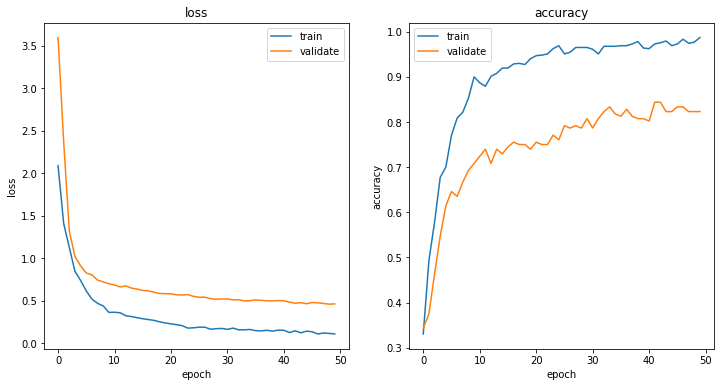

In [0]:
plot_history(history)

In [0]:
score = vgg.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 80.83% 
Test loss     = 0.539175


In [0]:
history = vgg.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=10,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/10
768/768 [==============================] - 5s 6ms/sample - loss: 0.0995 - accuracy: 0.9883 - val_loss: 0.4652 - val_accuracy: 0.8438
Epoch 2/10
768/768 [==============================] - 5s 6ms/sample - loss: 0.1071 - accuracy: 0.9883 - val_loss: 0.4688 - val_accuracy: 0.8281
Epoch 3/10
768/768 [==============================] - 5s 6ms/sample - loss: 0.1099 - accuracy: 0.9792 - val_loss: 0.4656 - val_accuracy: 0.8229
Epoch 4/10
768/768 [==============================] - 5s 6ms/sample - loss: 0.1148 - accuracy: 0.9779 - val_loss: 0.4592 - val_accuracy: 0.8333
Epoch 5/10
768/768 [==============================] - 5s 6ms/sample - loss: 0.1088 - accuracy: 0.9857 - val_loss: 0.4586 - val_accuracy: 0.8281
Epoch 6/10
768/768 [==============================] - 5s 6ms/sample - loss: 0.1087 - accuracy: 0.9805 - val_loss: 0.4492 - val_accuracy: 0.8125
Epoch 7/10
768/768 [==============================] - 5s 6ms/sample - loss: 0.1043 - accur

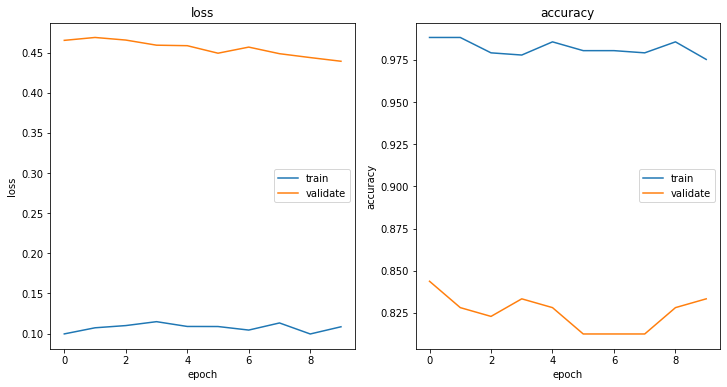

In [0]:
plot_history(history)

In [0]:
score = vgg.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 78.75% 
Test loss     = 0.529412


# Fine tune VGG16

In [0]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_4
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [0]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
# Make the whole base model trainable (using model property).
base_model.trainable = True
# How many trainable weights in the base model?
trainable_weights(base_model)
# Check that this agrees with the model summary.

14714688

In [0]:
# Set all layers not trainable (using layer properties).
for layer in base_model.layers:
   layer.trainable = False
# Set top two convolutional layers trainable.
for layer in base_model.layers[15:18]:
   layer.trainable = True
    
# How many trainable weights in the base model?
trainable_weights(base_model)
# Check that this agrees with the model summary.

7079424

In [0]:
vgg.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(lr=0.00001),
    metrics=['accuracy']
)

In [0]:
vgg.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                401424    
_________________________________________________________________
batch_normalization_6 (Batch (None, 16)                64        
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 68        
Total params: 15,116,244
Trainable params: 7,480,948
Non-trainable params: 7,635,296
___________________________________

In [0]:
history = vgg.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=10,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/10
768/768 [==============================] - 6s 8ms/sample - loss: 0.0961 - accuracy: 0.9805 - val_loss: 0.4533 - val_accuracy: 0.8385
Epoch 2/10
768/768 [==============================] - 5s 7ms/sample - loss: 0.1128 - accuracy: 0.9792 - val_loss: 0.4177 - val_accuracy: 0.8490
Epoch 3/10
768/768 [==============================] - 5s 7ms/sample - loss: 0.1033 - accuracy: 0.9870 - val_loss: 0.4150 - val_accuracy: 0.8333
Epoch 4/10
768/768 [==============================] - 5s 7ms/sample - loss: 0.1027 - accuracy: 0.9818 - val_loss: 0.4221 - val_accuracy: 0.8385
Epoch 5/10
768/768 [==============================] - 5s 7ms/sample - loss: 0.0872 - accuracy: 0.9896 - val_loss: 0.4219 - val_accuracy: 0.8385
Epoch 6/10
768/768 [==============================] - 5s 7ms/sample - loss: 0.1006 - accuracy: 0.9818 - val_loss: 0.4223 - val_accuracy: 0.8542
Epoch 7/10
768/768 [==============================] - 5s 7ms/sample - loss: 0.1006 - accur

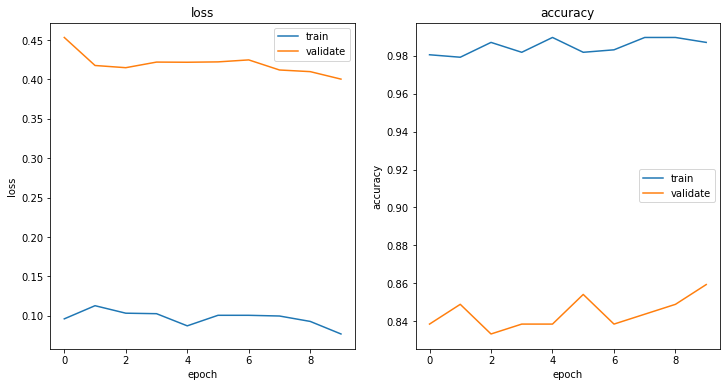

In [0]:
plot_history(history)

In [0]:
history = vgg.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/20
768/768 [==============================] - 5s 7ms/sample - loss: 0.0934 - accuracy: 0.9870 - val_loss: 0.3901 - val_accuracy: 0.8750
Epoch 2/20
768/768 [==============================] - 5s 7ms/sample - loss: 0.0860 - accuracy: 0.9922 - val_loss: 0.3869 - val_accuracy: 0.8646
Epoch 3/20
768/768 [==============================] - 5s 7ms/sample - loss: 0.0869 - accuracy: 0.9896 - val_loss: 0.3924 - val_accuracy: 0.8542
Epoch 4/20
768/768 [==============================] - 5s 7ms/sample - loss: 0.0870 - accuracy: 0.9909 - val_loss: 0.3946 - val_accuracy: 0.8646
Epoch 5/20
768/768 [==============================] - 5s 7ms/sample - loss: 0.0858 - accuracy: 0.9883 - val_loss: 0.3829 - val_accuracy: 0.8646
Epoch 6/20
768/768 [==============================] - 5s 7ms/sample - loss: 0.0777 - accuracy: 0.9909 - val_loss: 0.3742 - val_accuracy: 0.8698
Epoch 7/20
768/768 [==============================] - 5s 7ms/sample - loss: 0.0859 - accur

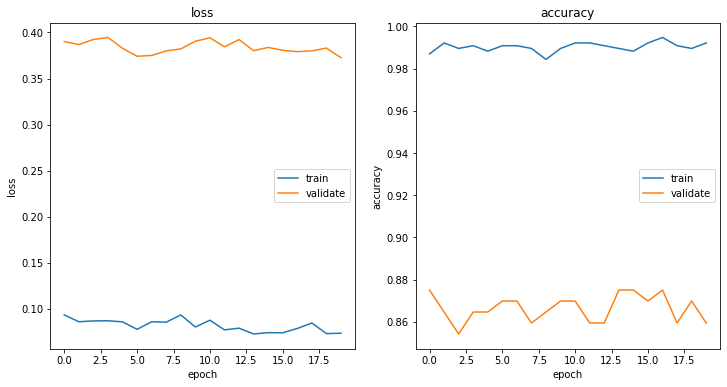

In [0]:
plot_history(history)

In [0]:
score = vgg.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 84.17% 
Test loss     = 0.432994


# VGG from scratch

In [32]:
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = True

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
vgg_scratch = build_network(base_model)

In [0]:
vgg_scratch.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(lr=1e-4),
    metrics=['accuracy']
)

In [37]:
history = vgg_scratch.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=10,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/10
768/768 [==============================] - 18s 24ms/sample - loss: 1.7969 - accuracy: 0.3047 - val_loss: 11.2717 - val_accuracy: 0.2031
Epoch 2/10
768/768 [==============================] - 11s 14ms/sample - loss: 1.3986 - accuracy: 0.3906 - val_loss: 6.4799 - val_accuracy: 0.2083
Epoch 3/10
768/768 [==============================] - 11s 14ms/sample - loss: 1.1078 - accuracy: 0.5169 - val_loss: 1.2789 - val_accuracy: 0.4740
Epoch 4/10
768/768 [==============================] - 11s 14ms/sample - loss: 0.9656 - accuracy: 0.5859 - val_loss: 1.0538 - val_accuracy: 0.5573
Epoch 5/10
768/768 [==============================] - 11s 14ms/sample - loss: 0.8043 - accuracy: 0.6784 - val_loss: 1.2645 - val_accuracy: 0.5417
Epoch 6/10
768/768 [==============================] - 11s 15ms/sample - loss: 0.7052 - accuracy: 0.7487 - val_loss: 0.9306 - val_accuracy: 0.6042
Epoch 7/10
768/768 [==============================] - 11s 15ms/sample - loss:

In [38]:
history = vgg_scratch.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=10,
    verbose=1,
    validation_split=0.2
)

Train on 768 samples, validate on 192 samples
Epoch 1/10
768/768 [==============================] - 11s 15ms/sample - loss: 0.4680 - accuracy: 0.9076 - val_loss: 0.7093 - val_accuracy: 0.8021
Epoch 2/10
768/768 [==============================] - 11s 15ms/sample - loss: 0.4662 - accuracy: 0.8919 - val_loss: 0.6111 - val_accuracy: 0.8438
Epoch 3/10
768/768 [==============================] - 11s 15ms/sample - loss: 0.4612 - accuracy: 0.9023 - val_loss: 0.6719 - val_accuracy: 0.7917
Epoch 4/10
768/768 [==============================] - 11s 15ms/sample - loss: 0.4412 - accuracy: 0.9062 - val_loss: 0.5750 - val_accuracy: 0.8542
Epoch 5/10
768/768 [==============================] - 11s 15ms/sample - loss: 0.4166 - accuracy: 0.9154 - val_loss: 0.6082 - val_accuracy: 0.8438
Epoch 6/10
768/768 [==============================] - 11s 15ms/sample - loss: 0.4484 - accuracy: 0.9219 - val_loss: 0.5797 - val_accuracy: 0.9167
Epoch 7/10
768/768 [==============================] - 12s 15ms/sample - loss: 

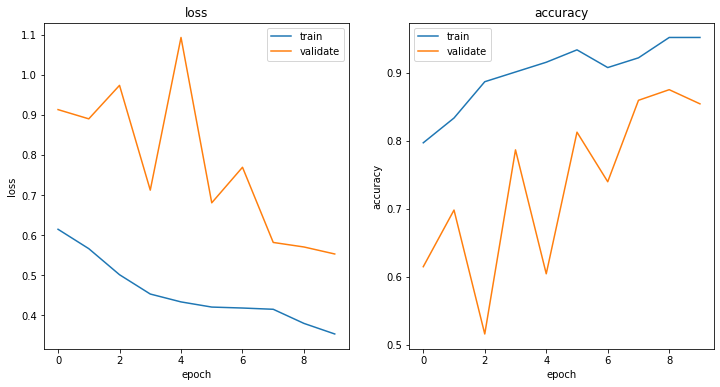

In [0]:
plot_history(history)

In [39]:
score = vgg_scratch.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 90.42% 
Test loss     = 0.511340


# Unseen data

In [0]:
def store_image(img_url, class_type):

  filename = ''
  response = requests.get(img_url)

  if response.status_code == 200:
    directory = 'car-dataset/train/{}'.format(class_type)
    os.chdir(directory)
    filename = str(max(sorted([int(prefix.split('.')[0]) for prefix in os.listdir()])) + 1)

    with open('{}.jpg'.format(filename), 'wb') as f:
      f.write(response.content)

    os.chdir('../../..')

  return directory + '/{}.jpg'.format(filename)

In [0]:
def classify(img_url, class_type, **trained_model):
  
  filename = store_image(img_url, class_type)
  img = image.load_img(filename, target_size=(224, 224))
  plt.imshow(np.squeeze(img).astype('uint8'))

  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img/255.0

  for name, model in trained_model.items(): 
    golf = model.predict_classes(img)
    if (golf == 0):
      golf = '7.5'
    elif (golf == 1):
      golf = '7'
    elif (golf == 2):#se:
      golf = '6'
    else: 
      golf = 5
    print('Classifier:', name)
    print('Golf model:', golf, ', proba:', model.predict_proba(img), '\n')

### Golf 5

In [44]:
classify(
    'https://www.carmag.co.za/car-images/Gauteng/6091-648349_5/2007-Volkswagen-GOLF-5-GOLF-2.0-COMFORTLINE-5.jpeg',
    '5', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

NameError: ignored

### Golf 6

Classifier: vgg_model
Golf model: 6 , proba: [[0.00762263 0.0606554  0.89848083 0.0332412 ]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.02699837 0.2141085  0.43622705 0.32266605]] 

Classifier: resnet_transfer_model
Golf model: 7.5 , proba: [[0.39466634 0.31545547 0.1253273  0.16455087]] 



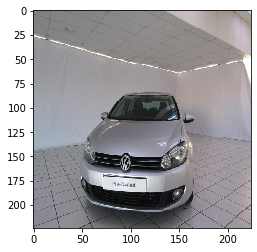

In [0]:
classify(
    'https://img.autotrader.co.za/3760195/Crop800x600',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.00789075 0.06292483 0.89628506 0.03289928]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.02672531 0.20352423 0.44144592 0.3283045 ]] 

Classifier: resnet_transfer_model
Golf model: 7.5 , proba: [[0.389687   0.31597486 0.12636192 0.1679762 ]] 



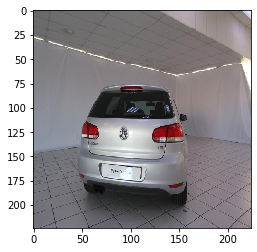

In [0]:
classify(
    'https://img.autotrader.co.za/3760198/Crop800x600',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.00878887 0.06175552 0.89543796 0.03401763]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.02495037 0.1951461  0.44919115 0.33071232]] 

Classifier: resnet_transfer_model
Golf model: 7.5 , proba: [[0.38352126 0.3173993  0.13112508 0.16795437]] 



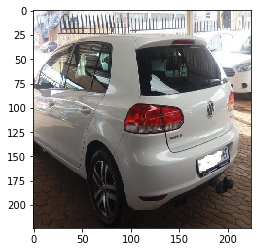

In [0]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5416351_5.jpg?v=1868034972',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.00852136 0.05788811 0.8994419  0.03414862]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.02619421 0.20634174 0.4287225  0.33874154]] 

Classifier: resnet_transfer_model
Golf model: 7.5 , proba: [[0.38728777 0.3259724  0.1275109  0.15922901]] 



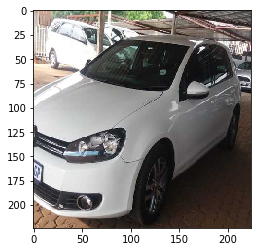

In [0]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5416351.jpg?v=1868034972',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.00780509 0.06762327 0.88948023 0.03509138]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.02488242 0.19156922 0.46058312 0.3229652 ]] 

Classifier: resnet_transfer_model
Golf model: 7.5 , proba: [[0.38741586 0.32284287 0.12684388 0.16289738]] 



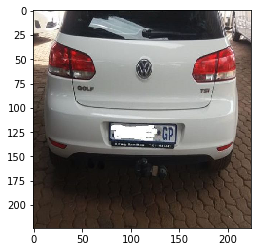

In [0]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5416351_6.jpg?v=1868034972',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.00863288 0.05973151 0.8985148  0.03312081]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.02285531 0.21301179 0.44389975 0.3202332 ]] 

Classifier: resnet_transfer_model
Golf model: 7.5 , proba: [[0.40147606 0.30689713 0.13410282 0.15752393]] 



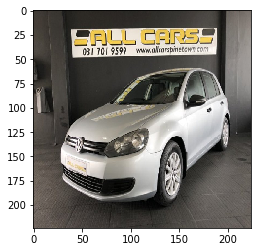

In [0]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_large/5532964.jpg?v=125421204',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.0090589  0.0625879  0.89330965 0.03504358]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.02456625 0.2094649  0.44742215 0.3185467 ]] 

Classifier: resnet_transfer_model
Golf model: 7.5 , proba: [[0.3788224  0.31638655 0.13728052 0.16751052]] 



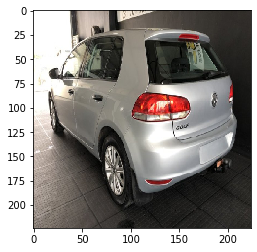

In [0]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_large/5532964_3.jpg?v=125421204',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.00911385 0.06591841 0.89049435 0.03447339]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.02549536 0.20119487 0.43896538 0.33434436]] 

Classifier: resnet_transfer_model
Golf model: 7.5 , proba: [[0.39177293 0.3149846  0.13219723 0.16104525]] 



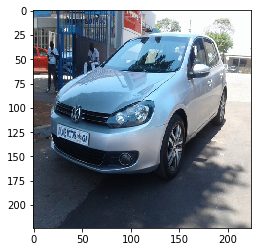

In [0]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518.jpg?v=2265708515',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.00819866 0.06253496 0.8961982  0.03306819]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.02639162 0.21957287 0.42894903 0.32508644]] 

Classifier: resnet_transfer_model
Golf model: 7.5 , proba: [[0.39019525 0.32058218 0.12994462 0.15927796]] 



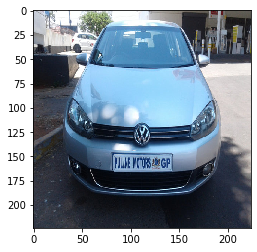

In [0]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518_2.jpg?v=2265708515',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.00849168 0.05393201 0.90749973 0.03007649]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.02338668 0.19477868 0.45419696 0.3276377 ]] 

Classifier: resnet_transfer_model
Golf model: 7.5 , proba: [[0.3839156  0.32854918 0.12693343 0.1606018 ]] 



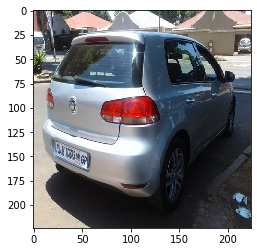

In [0]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518_8.jpg?v=2265708515',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.00851199 0.06585798 0.89208233 0.03354765]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.02374221 0.20315726 0.4497022  0.32339838]] 

Classifier: resnet_transfer_model
Golf model: 7.5 , proba: [[0.38140833 0.31710443 0.14112997 0.1603573 ]] 



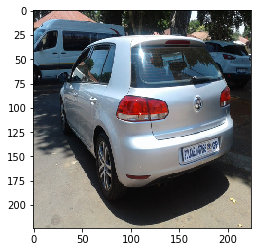

In [0]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518_7.jpg?v=2265708515',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.00845364 0.06363728 0.8950032  0.0329059 ]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.02486356 0.20689036 0.43895233 0.32929373]] 

Classifier: resnet_transfer_model
Golf model: 7.5 , proba: [[0.3815659  0.33044836 0.12930557 0.15868017]] 



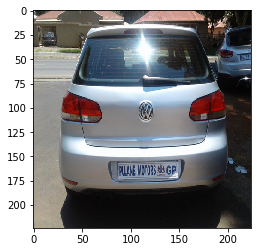

In [0]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518_6.jpg?v=2265708515',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_model
Golf model: 6 , proba: [[0.00752276 0.0585168  0.9021418  0.03181865]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.02543472 0.22894052 0.41609636 0.3295284 ]] 

Classifier: resnet_transfer_model
Golf model: 7.5 , proba: [[0.41136348 0.3005271  0.13662548 0.15148391]] 



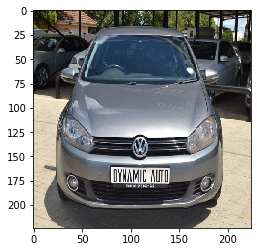

In [0]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5530306_2.jpg?v=4074465811',
    '6', vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

### Golf 7


Classifier: vgg_scratch
Golf model: 5 , proba: [[0.15668769 0.03431454 0.32448485 0.48451293]] 

Classifier: vgg_model
Golf model: 6 , proba: [[0.00881481 0.06146254 0.8982607  0.03146191]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.02494974 0.20443265 0.43458846 0.33602914]] 

Classifier: resnet_transfer_model
Golf model: 7.5 , proba: [[0.38714358 0.316677   0.12896417 0.16721521]] 



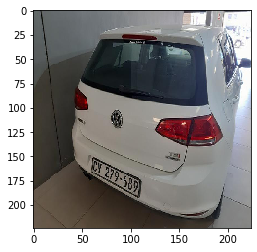

In [0]:
classify(
    'https://img.autotrader.co.za/4873898/Crop800x600',
    '7', vgg_scratch = vgg_scratch, vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_scratch
Golf model: 5 , proba: [[0.14920053 0.02170403 0.33530995 0.49378544]] 

Classifier: vgg_model
Golf model: 6 , proba: [[0.00896536 0.07038687 0.8863397  0.03430809]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.02627969 0.22488023 0.42489403 0.32394606]] 

Classifier: resnet_transfer_model
Golf model: 7.5 , proba: [[0.38431126 0.3289053  0.12750031 0.15928316]] 



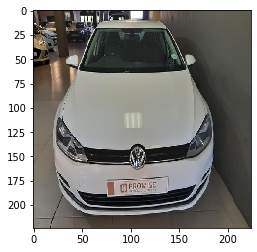

In [0]:
classify(
         'https://img.autotrader.co.za/4873896/Crop800x600',
         '7', vgg_scratch = vgg_scratch, vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
         )

Classifier: vgg_scratch
Golf model: 5 , proba: [[0.15688372 0.03366047 0.32247815 0.48697767]] 

Classifier: vgg_model
Golf model: 6 , proba: [[0.0085114  0.06435768 0.8932221  0.03390882]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.02616891 0.20442726 0.43148336 0.33792046]] 

Classifier: resnet_transfer_model
Golf model: 7.5 , proba: [[0.39506304 0.32429662 0.1205167  0.16012362]] 



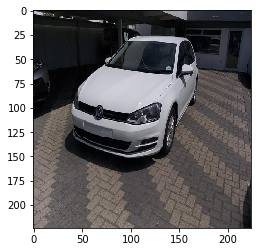

In [0]:
classify(
         'https://img.autotrader.co.za/5248234/Crop800x600',
         '7', vgg_scratch = vgg_scratch, vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
         )


Classifier: vgg_scratch
Golf model: 5 , proba: [[0.15368344 0.02882361 0.3241942  0.4932988 ]] 

Classifier: vgg_model
Golf model: 6 , proba: [[0.00843158 0.07008783 0.88744175 0.03403893]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.02591554 0.21555759 0.43124133 0.3272855 ]] 

Classifier: resnet_transfer_model
Golf model: 7.5 , proba: [[0.3838976  0.32559597 0.12606439 0.164442  ]] 



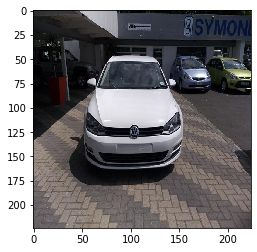

In [0]:
classify(
         'https://img.autotrader.co.za/5248233/Crop800x600',
         '7', vgg_scratch = vgg_scratch, vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
         )

### Golf 7.5

Classifier: vgg_scratch
Golf model: 5 , proba: [[0.15527692 0.02961946 0.3287477  0.48635593]] 

Classifier: vgg_model
Golf model: 6 , proba: [[0.00894948 0.07356148 0.8840988  0.0333902 ]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.02563626 0.23208922 0.41482386 0.32745066]] 

Classifier: resnet_transfer_model
Golf model: 7.5 , proba: [[0.39740002 0.31722233 0.12611301 0.15926468]] 



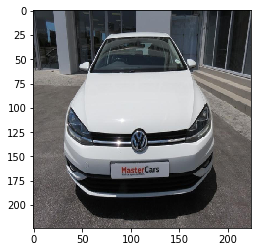

In [0]:
classify(
    'https://img.autotrader.co.za/4971489/Crop800x600',
    '7_5', vgg_scratch = vgg_scratch, vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_scratch
Golf model: 5 , proba: [[0.15681195 0.0334783  0.32562938 0.48408034]] 

Classifier: vgg_model
Golf model: 6 , proba: [[0.00871788 0.06009811 0.89872205 0.03246184]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.02481765 0.203072   0.4335271  0.3385833 ]] 

Classifier: resnet_transfer_model
Golf model: 7.5 , proba: [[0.3838036  0.3234333  0.13106366 0.16169944]] 



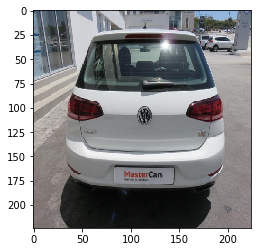

In [0]:
classify(
    'https://img.autotrader.co.za/4971493/Crop800x600',
    '7_5', vgg_scratch = vgg_scratch, vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_scratch
Golf model: 5 , proba: [[0.15830563 0.0321005  0.32748878 0.48210514]] 

Classifier: vgg_model
Golf model: 6 , proba: [[0.00916762 0.06531634 0.89304876 0.03246724]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.02556229 0.20340057 0.4365941  0.33444303]] 

Classifier: resnet_transfer_model
Golf model: 7.5 , proba: [[0.3832345  0.32035783 0.1315715  0.1648362 ]] 



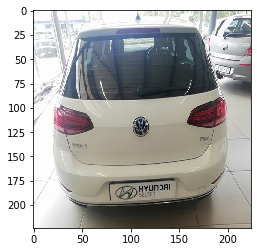

In [0]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5570873_6.jpg?v=317154964',
    '7_5', vgg_scratch = vgg_scratch, vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_scratch
Golf model: 5 , proba: [[0.1581203  0.03354377 0.32515243 0.48318347]] 

Classifier: vgg_model
Golf model: 6 , proba: [[0.00989345 0.06901863 0.8846348  0.03645308]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.02561033 0.220723   0.42523476 0.32843196]] 

Classifier: resnet_transfer_model
Golf model: 7.5 , proba: [[0.392934   0.31806195 0.12611131 0.16289273]] 



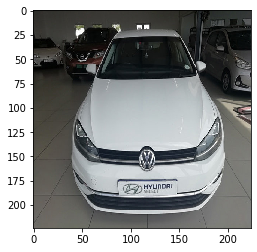

In [0]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5570873_3.jpg?v=317154964',
    '7_5', vgg_scratch = vgg_scratch, vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_scratch
Golf model: 5 , proba: [[0.15569466 0.02891482 0.32625234 0.48913822]] 

Classifier: vgg_model
Golf model: 6 , proba: [[0.00870532 0.06435531 0.893303   0.03363634]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.02610713 0.20954275 0.4303639  0.33398622]] 

Classifier: resnet_transfer_model
Golf model: 7.5 , proba: [[0.3977674  0.31573546 0.12994449 0.15655266]] 



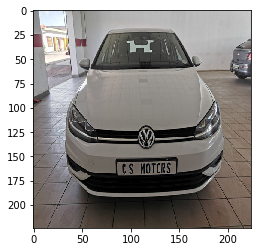

In [0]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5428529_2.jpg?v=158700226',
    '7_5', vgg_scratch = vgg_scratch, vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

Classifier: vgg_scratch
Golf model: 5 , proba: [[0.15713224 0.03013665 0.32579568 0.48693544]] 

Classifier: vgg_model
Golf model: 6 , proba: [[0.0082281  0.06257124 0.89688176 0.03231887]] 

Classifier: resnet_model
Golf model: 6 , proba: [[0.02386698 0.20828432 0.44075835 0.32709035]] 

Classifier: resnet_transfer_model
Golf model: 7.5 , proba: [[0.38882527 0.3204786  0.12853932 0.16215688]] 



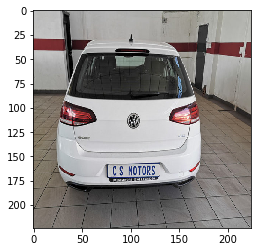

In [0]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5428529_7.jpg?v=158700226',
    '7_5', vgg_scratch = vgg_scratch, vgg_model = vgg, resnet_model = resnet50, resnet_transfer_model = resnet50_tl
)

In [0]:
# 1. Change classify function to accept multiple models
# 2. Build simple network to count side/front/rear shots of each class
# 3. Investigate network ensemble